# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 


## Advanced Section: Homework 8: Reinforcement Learning [50 pts]


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>

**DISCLAIMER**: No public reproduction of this homework nor its solution is allowed without the explicit consent of their authors.



<hr style="height:2pt">

---

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit.
- Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
# Numpy and plotting libraries

import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

<div class='exercise'><b> Question 1: Basic RL algorithms [20 points]</b></div>

You will explore the behavior of SARSA and Q-learning in the cliffworld domain
(similar to the example given on p132 of Sutton and Barto).

Agents begin in the start state and can take actions in the set {up, down, left, right}. The episode ends when they reach the goal state, where they receive a reward of 50. Moving or bumping into a wall incurs a small -1 penalty, while falling off the cliff incurs a greviously painful -50 penalty.


**1.1**  [4 pts] Complete function `epsilon_greedy_action` that while being in `state`, chooses a random action with probability $\epsilon$ , or chooses a best action from Q with probability $1-\epsilon$.

**1.2**  [4 pts]  Implement the update steps of SARSA and Q-Learning (p130-131 of Sutton and Barto) in function `do_simulations`. Assume SARSA approximates the Q-function following an $\epsilon$-greedy action strategy.

**1.3**  [4 pts] Run both of these algorithms, let the step size $\alpha$ be 0.1, and initialize Q (i.e. pass Q initial) to three possible settings:
* Q initial = -50
* Q initial = 0
* Q initial = 50
Let the discount factor $\gamma = 0.95$  and assume an $\epsilon$-greedy action strategy with $\epsilon$ = 0.1. Keep the environment deterministic. 

For each pair of algorithm and parameter setting, run 50 separate trials. Let each trial run for at least 5000 iterations of experience and at least 100 episodes (that is, the number of iterations will be max(5000, iterations it takes to run 100 episodes)).

REMARK: you will use the learned policies in the next questions. We encourage you to save the results of the simulations on a dictionary you can easily access by `(method, Q_initial)` for later reuse.

**1.4**  [4 pts] Plot the learned policies returned by `run_simulations` on the different scenarios described in 2.3 (6 in total: 2 methods x 3 Q initial values). Use function `plot_policy` we provide to make the figures.

**1.5**  [4 pts] Plot the policy that solves the MDP, i.e., `true_Q`. Compare and explain the resulting plots from 2.4 plots and the `true_Q` plot.

**1.6** \[OPTIONAL\] Plot the average cumulative reward (no discount factor, averaged across the 50 trials) vs. the number of episodes for each case, for the first 100 episodes. Use a different color for each algorithm, and a different line style for the different parameter settings. You may use `episode_rewards` results returned by `run_simulations` from each of the simulations.
 
**1.7** \[OPTIONAL\] Using the values of Q(s, a) you obtained for each algorithm, parameter setting, and trial, let your agent run for 5 additional episodes, but with different random action probabilities $\epsilon$ in {0, 0.01, 0.1, 0.25, 0.33, 0.5}. Store the cumulative reward obtained in each case. This metric captures how well the agent is doing once it's 'done' learning (that is, is it getting close to an optimal reward?) at different levels of action stochasticity. Then make a similar plot as in 2.6 (different color for each algorithm, different line-type for each parameter setting), but with $\epsilon$ on the x-axis and post-training, 5-episode cumulative reward (averaged over the 50 trials) on the y-axis. You may use `evaluate_static_policy` to compute the cumulative reward evaluated over 5 additional episodes.

### Create cliffworld

Run the following two cells to create a cliffworld. You will learn policies by running SARSA and Q-learning on it! 

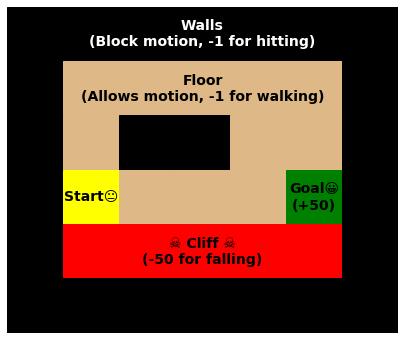

In [3]:
from gridworld import GridWorld
MAX_STEPS_PER_EPISODE = 100 # Prevent infinitely long episodes


def cliffworld():
    """Construct the "cliffworld" environment."""
    return GridWorld(
        maze=[
            '#######',
            '#.....#',
            '#.##..#',
            '#o...*#',
            '#XXXXX#',
            '#######'
        ],
        rewards={
            '*': 50,         # gain 50 points for reaching goal
            'X': -50,        # lose 50 points for falling down
            'moved': -1,     # lose 1 point for walking
            'hit-wall': -1   # lose 1 point for stumbling into a wall
        }
    )

# Create cliffworld
env = cliffworld()

# Paint cliffworld
def square(x,y,**kw):
  plt.axhspan(y,y+1,xmin=x/7,xmax=(x+1)/7,**kw)

colors = {'#': 'black', '.': 'burlywood', 'X': 'red', '*': 'green', 'o': 'yellow'}

plt.figure(figsize=(7,6))

for y,row in enumerate(env.maze.topology):
  for x,cell in enumerate(row):
    square(x,5-y,color=colors[cell])
    
plt.axis('off')
plt.text(1.5,2.5,'Start😐', va='center', ha='center', fontweight='bold', fontsize=14)
plt.text(5.5,2.5,"Goal😀\n(+50)", va='center', ha='center', fontweight='bold', fontsize=14)
plt.text(3.5,1.5,"☠️ Cliff ☠️\n(-50 for falling)", va='center', ha='center', fontweight='bold', fontsize=14)
plt.text(3.5,5.5,"Walls\n(Block motion, -1 for hitting)", color='white', va='center', ha='center', fontweight='bold', fontsize=14)
plt.text(3.5,4.5,"Floor\n(Allows motion, -1 for walking)", va='center', ha='center', fontweight='bold', fontsize=14)
plt.xlim(0,7)
plt.ylim(0,6)

plt.show()

**1.1**  [4 pts] Complete function `epsilon_greedy_action` that while being in `state`, chooses a random action with probability $\epsilon$ , or chooses a best action from Q with probability $1-\epsilon$.


In [4]:
# 1.1

def epsilon_greedy_action(state, Q, epsilon=0.1):
    """Select a random action with probability epsilon or the action suggested
    by Q with probability 1-epsilon.
    Inputs:
    -state: current state.
    -Q: 2D numpy array of dimensions (num_states, num_actions).
    -epsilon: probability of randomizing an action.
    
    Retuns: action."""
    # your code here
    if np.random.uniform()<=epsilon:
        action_idx = np.random.randint(0,4)
    else:
        action_idx = np.argmax(Q[state,:])
    return action_idx
    # end your code here

**1.2**  [4 pts]  Implement the update steps of SARSA and Q-Learning (p130-131 of Sutton and Barto) in function `do_simulations`. Assume SARSA approximates the Q-function following an $\epsilon$-greedy action strategy.


In [5]:
# 1.2

def run_simulation(
        # Common parameters
        env,
        method,
        min_num_episodes=100,
        min_num_iters=5000,
        epsilon=0.1,
        discount=0.95,
        # SARSA/Q-learning parameters
        step_size=0.5,
        Q_initial=0.0,
    ):
    # Ensure valid parameters
    if method not in ('SARSA', 'Q-learning'):
        raise ValueError("method not in {SARSA, Q-learning}")

    # Initialize arrays for our estimate of Q and observations about T and R,
    # and our list of rewards by episode
    num_states, num_actions = env.num_states, env.num_actions
    Q = np.zeros((num_states, num_actions)) + Q_initial
    observed_T_counts = np.zeros((num_states, num_actions, num_states))
    observed_R_values = np.zeros((num_states, num_actions, num_states))
    episode_rewards = []
    num_cliff_falls = 0
    global_iter = 0

    # Loop through episodes
    while len(episode_rewards) < min_num_episodes or global_iter < min_num_iters:
        # Reset environment and episode-specific counters
        env.reset()
        episode_step = 0
        episode_reward = 0

        # Get our starting state
        s1 = env.observe()

        # Loop until the episode completes
        while not env.is_terminal(s1) and episode_step < MAX_STEPS_PER_EPISODE:
            # Take eps-best action & receive reward
            a = epsilon_greedy_action(s1, Q, epsilon)
            s2, r = env.perform_action(a)

            # Update counters
            episode_step += 1
            episode_reward += r
            observed_T_counts[s1][a][s2] += 1
            observed_R_values[s1][a][s2] = r
            num_cliff_falls += env.is_cliff(s2)

            # Use one of the RL methods to update Q
            if method == 'SARSA':
                """Implements SARSA update step in Q from Section 6.4, Sutton and
                Barto (p130). SARSA chooses next action based on `epsilon_greedy_action`."""
                
                # your code here
                a2 = epsilon_greedy_action(s2, Q, epsilon)
                target = r + discount*Q[s2,a2]
                Q[s1,a] = Q[s1,a] + step_size*(target-Q[s1,a])

                # end your code here
                
            elif method == 'Q-learning':
                """Implement Q-learning update step from Section 6.4, Sutton
                and Barto (p131)"""
                
                # your code here
                a2 = np.argmax(Q[s2])
                target = r + discount*Q[s2,a2]
                Q[s1,a] = Q[s1,a] + step_size*(target-Q[s1,a])
                # end your code here
                
            s1 = s2
            global_iter += 1

        episode_rewards.append(episode_reward)

    return { 'Q': Q,
            'num_cliff_falls': num_cliff_falls,
            'episode_rewards': np.array(episode_rewards) }

### Run SARSA and Q-learning

**1.3**  [4 pts] Run both of these algorithms, let the step size $\alpha$ be 0.1, and initialize Q (i.e. pass Q initial) to three possible settings:
* Q initial = -50
* Q initial = 0
* Q initial = 50
Let the discount factor $\gamma = 0.95$  and assume an $\epsilon$-greedy action strategy with $\epsilon$ = 0.1. Keep the environment deterministic.

For each pair of algorithm and parameter setting, run 50 separate trials. Let each trial run for at least 5000 iterations of experience and at least 100 episodes (that is, the number of iterations will be max(5000, iterations it takes to run 100 episodes)).

REMARK: you will use the learned policies in the next questions. We encourage you to save the results of the simulations on a dictionary you can easily access by `(method, Q_initial)` for later reuse.


In [6]:
# 1.3
# your code here

alpha = 0.1
gamma = 0.95
epsilon = 0.1

n_trials=50
min_iterations=5000
n_episodes = 100

#'result' is the dictionary to store the simulation results 
# - the key being the combination of the pair (Q_init, method)
# - the values will be a list of length n_trials, 
#   and each entry of this list is a dict of the results (Q,num_cliff_falls, episode_rewards)
result = {} 
for Q_init in [-50, 0, 50]:
    for method in ['SARSA', 'Q-learning']:
        trial_results = [None]*n_trials #initialize empty array to later store the results of the simulation
        for trial in range(n_trials):
            trial_results[trial] = run_simulation(env, method, min_num_episodes=n_episodes, min_num_iters=min_iterations, 
                                            epsilon=epsilon, discount=gamma, step_size=alpha, Q_initial=Q_init)
        result[(Q_init, method)] = trial_results


### Plot Policy function:

In [7]:
def plot_policy(env, Q):
    row_count, col_count = env.maze_dimensions
    maze_dims = (row_count, col_count)
    value_function = np.reshape(np.max(Q, 1), maze_dims)
    policy_function = np.reshape(np.argmax(Q, 1), maze_dims)
    wall_info = .5 + np.zeros(maze_dims)
    wall_mask = np.zeros(maze_dims)
    for row in range(row_count):
        for col in range(col_count):
            if env.maze.topology[row][col] == '#':
                wall_mask[row,col] = 1
    wall_info = np.ma.masked_where(wall_mask==0, wall_info)
    value_function *= (1-wall_mask)**2
    plt.imshow(value_function, interpolation='none', cmap='jet')
    plt.colorbar(label='Value Function')
    plt.imshow(wall_info, interpolation='none' , cmap='gray')
    y,x = env.maze.start_coords
    plt.text(x,y,'start', color='gray', fontsize=14, va='center', ha='center', fontweight='bold')
    y,x = env.maze.goal_coords
    plt.text(x,y,'goal', color='yellow', fontsize=14, va='center', ha='center', fontweight='bold')
    for row in range( row_count ):
        for col in range( col_count ):
            if wall_mask[row][col] == 1:
                continue
            if policy_function[row,col] == 0:
                dx = 0; dy = -.5
            if policy_function[row,col] == 1:
                dx = 0; dy = .5
            if policy_function[row,col] == 2:
                dx = .5; dy = 0
            if policy_function[row,col] == 3:
                dx = -.5; dy = 0
            plt.arrow(col, row, dx, dy,
                shape='full', fc='w' , ec='w' , lw=3, length_includes_head=True, head_width=.2)
    plt.xlabel("X-Coordinate")
    plt.ylabel("Y-Coordinate")

**1.4**  [4 pts] Plot the learned policies returned by `run_simulations` on the different scenarios described in 2.3 (6 in total: 2 methods x 3 Q initial values). Use function `plot_policy` we provide to make the figures.


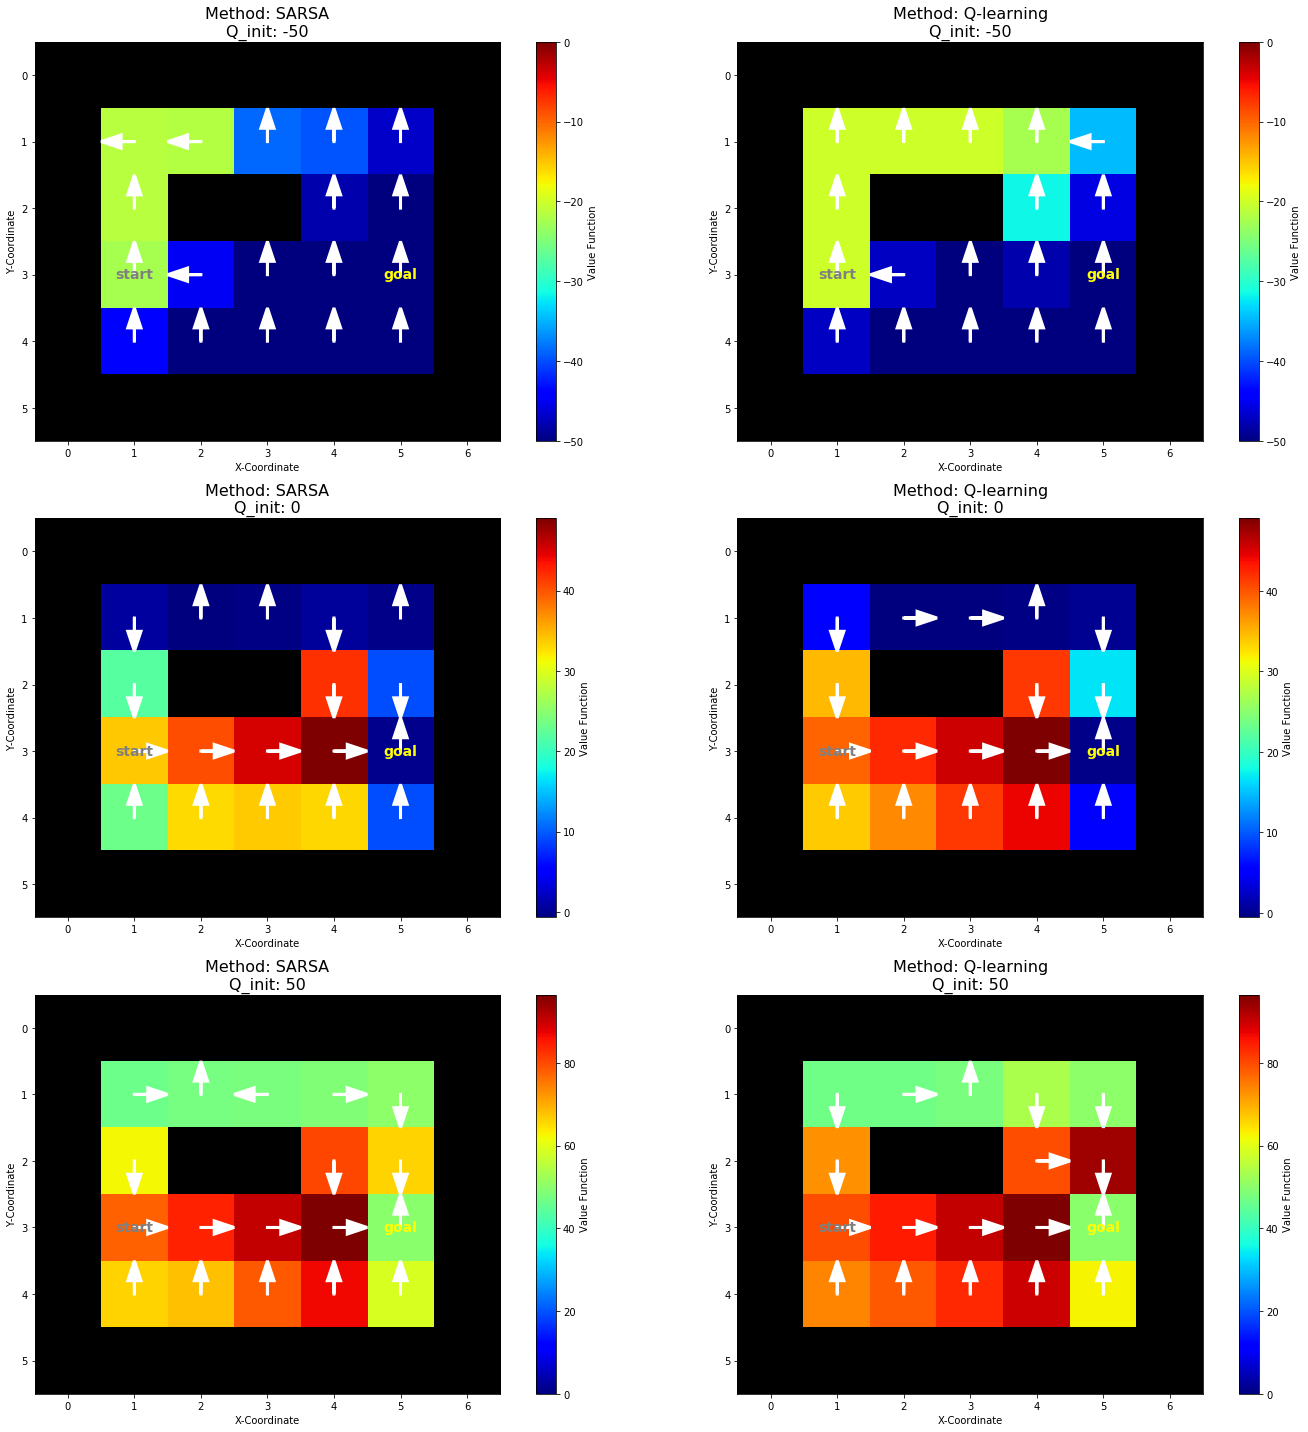

In [8]:
# 1.4
# your code here

fig, ax = plt.subplots(3,2,figsize=(20,20))

for idx, dict_keys in enumerate(result.keys()):
    ax[idx//3,idx%2] = plt.subplot(3,2,idx+1)
    Q_for_plot = result[dict_keys][8]['Q'] #plot the result from one the trials
    plot_policy(env, Q_for_plot)
    title='Method: '+dict_keys[1]+'\nQ_init: '+str(dict_keys[0])
    ax[idx//3,idx%2].set_title(title, fontsize=16)
plt.tight_layout()

In [13]:
print('Num_cliff_falls: ')
result
for idx, dict_keys in enumerate(result.keys()):
    print(dict_keys, ": ",result[dict_keys][idx]['num_cliff_falls'])

Num_cliff_falls: 
(-50, 'SARSA') :  1
(-50, 'Q-learning') :  5
(0, 'SARSA') :  150
(0, 'Q-learning') :  139
(50, 'SARSA') :  126
(50, 'Q-learning') :  136


### HW8 Commpletion

For the next question, you need to use the functions you completed in HW8. Complete the skeleton of these functions before attempting 2.5:

In [14]:
class MDP(object):
    """Wrapper for a discrete Markov decision process that makes shape checks"""
    
    def __init__(self, T, R, discount):
        """Initialize the Markov Decision Process.
        - `T` should be a 3D array whose dimensions represent initial states,
          actions, and next states, respectively, and whose values represent
          transition probabilities.
        - `R` should be a 1D array describing rewards for beginning each
          timestep in a particular state (or a 3D array like `T`). It will be
          transformed into the appropriate 3D shape.
        - `discount` should be a value in [0,1) controlling the decay of future
          rewards."""
        Ds, Da, _ = T.shape
        if T.shape not in [(Ds, Da, Ds)]:
            raise ValueError("T should be in R^|S|x|A|x|S|")
        if R.shape not in [(Ds, Da, Ds), (Ds,)]:
            raise ValueError("R should be in R^|S| or like T")
        if discount < 0 or discount >= 1:
            raise ValueError("discount should be in [0,1)")
        if R.shape == (Ds,):  # Expand R if necessary
            R = np.array([[[R[s1] for s2 in range(Ds)] for a in range(Da)] for s1 in range(Ds)])
        self.T = T
        self.R = R
        self.discount = discount
        self.num_states = Ds
        self.num_actions = Da
        self.states = np.arange(Ds)
        self.actions = np.arange(Da)
      
    
def iterative_value_estimation(mdp, policy, tol=1e-5):
    """Value estimation algorithm from page 75, Sutton and Barto. Returns an
    estimate of the value of a given policy under the MDP (with the number of
    iterations required to reach specified tolerance)."""
    V = np.zeros(mdp.num_states)
    num_iters = 0
    
    # your code here
    while True:       
        #new value function
        V_new = np.zeros(mdp.num_states)   
        #stopping condition
        delta = 0
        
        for state in range(mdp.num_states):  
            V_fn = 0
            action = policy[state]
            reward = mdp.R[state,action,0]
            value_nextstate = 0
            for next_state in range(mdp.num_states):
                transition_prob = mdp.T[state,action,next_state]
                value_nextstate += transition_prob*V[next_state]
                    
            V_fn += reward + mdp.discount* value_nextstate
            
            #get the biggest difference over state space
            delta = max(delta, abs(V_fn - V[state]))
            V_new[state] = V_fn #update state-value

        num_iters += 1
        V = V_new #the new value function

        #if true value function
        if(delta < tol):
            break     
    
    # your code ends here
    return V, num_iters


def Q_function(mdp, policy, tol=1e-5):
    """Q function from Equation 4.6, Sutton and Barto. For each state and
    action, returns the value of performing the action at that state, then
    following the policy thereafter."""
    # your code here
    
    Q = np.zeros((mdp.num_states, mdp.num_actions))
    
    # Rewards for each starting point
    V_policy, n_iter = iterative_value_estimation(mdp, policy, tol)
    
    #initial state's reward
    V_init = mdp.R[:,0,0].copy()

    for states in range(mdp.num_states):
        for actions in range(mdp.num_actions):
            value_nextstate = 0
            for next_state in range(mdp.num_states):
                transition_prob = mdp.T[states,actions,next_state]
                value_nextstate += transition_prob*V_policy[next_state]
                
            Q[states,actions] = V_init[states] + mdp.discount * value_nextstate
    
    # your code ends here
    assert Q.shape == (mdp.num_states, mdp.num_actions)
    return Q
    

def policy_iteration(mdp, init_policy=None, tol=1e-5):
    """Policy iteration algorithm from page 80, Sutton and Barto.
    Iteratively transform the initial policy to become optimal.
    Return the full path."""
    if init_policy is None:
        init_policy = np.zeros(mdp.num_states, dtype=int)
    policies = [np.array(init_policy)]
    
    # your code here
    
    policy = init_policy

    while True:
        value_fn = iterative_value_estimation(mdp, policy, tol)[0]
        policy_stable = True
        
        for s in range(mdp.num_states):
            action_values = Q_function(mdp, policy, tol)[s,:]
            best_action = np.argmax(action_values) #best action, based on q function
            chosen_action = policy[s]#best action, given current policy
        
            #if Bellman optimality equation not satisifed
            if(best_action != chosen_action):
                policy_stable = False
                policy[s] = best_action
        
        policies = np.concatenate((policies,[policy]))
        
        #if Bellman optimality eqn is satisfied
        if(policy_stable):
            break        
    
    # end your code here
    return policies

**1.5**  [4 pts] Plot the policy that solves the MDP, i.e., `true_Q`. Compare and explain the resulting plots from 2.4 plots and the `true_Q` plot.


In [15]:
def true_Q_function(env, discount=0.95):
    """Return the true value of the Q function using the actual MDP / Q1 code.

    NOTE: Please only use this for testing/comparison, not policy learning!"""
    true_T, true_R = env.as_mdp()
    true_mdp = MDP(true_T, true_R, discount)
    true_pi_star = policy_iteration(true_mdp)[-1]
    return Q_function(true_mdp, true_pi_star)

true_Q = true_Q_function(env)

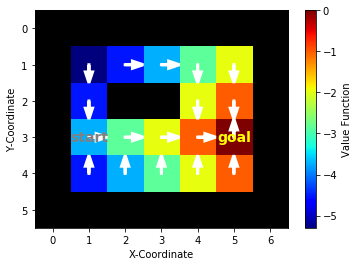

In [16]:
# 2.5
# your code here
plot_policy(env, true_Q)

**Explain your results:**

*Your answer here*

In Q learning, we update the estimate from the maximum estimate of possible next actions, regardless of which action we took. Whilst in SARSA, we update estimates based on and take the same action. 

The ideal plot (Q1.5) shows how the value increasing as we get closer to the goal. But in Q1.4, we can see that the direction/action presented in the top row is all over the place (a lot of up/left arrow) while it should go to the right and then down. Comparison between the true solution above vs Q-learning & SARSA:

- SARSA will approach convergence allowing for possible penalties from exploratory moves, whilst Q-learning will ignore them. That makes SARSA more conservative - if there is risk of a large negative reward close to the optimal path, Q-learning will tend to trigger that reward whilst exploring, whilst SARSA will tend to avoid a dangerous optimal path and only slowly learn to use it when the exploration parameters are reduced. This is clearly represented in the plot above (Q_init = 0/50): in the top row, SARSA often gives out 'up' direction because it's trying to avoid the cliff at the bottom as much as possible, while we see Q-learning gives out more of the 'down/right' action


- Q-learning directly learns the optimal policy, whilst SARSA learns a near-optimal policy whilst exploring. If we want to learn an optimal policy using SARSA, then we will need to decide on a strategy to decay 𝜖 in 𝜖-greedy action choice, which may become a fiddly hyperparameter to tune.


**1.6** \[OPTIONAL\] Plot the average cumulative reward (no discount factor, averaged across the 50 trials) vs. the number of episodes for each case, for the first 100 episodes. Use a different color for each algorithm, and a different line style for the different parameter settings. You may use `episode_rewards` results returned by `run_simulations` from each of the simulations.


In [17]:
# 2.6
# your code here
alpha = 0.1
gamma = 1 #no discount factor
epsilon = 0.1

n_trials=50
min_iterations=5000
n_episodes = 100

# result_rewards = {}
avg_100_rewards = {}
for Q_init in [-50, 0, 50]:
    for method in ['SARSA', 'Q-learning']:
        avg_100 = np.zeros((n_trials, 100)) #initialize empty array to later store the results of the simulation
        for trial in range(n_trials):
            temp = run_simulation(env, method, min_num_episodes=n_episodes,min_num_iters=min_iterations, 
                                  epsilon=epsilon, discount=gamma, step_size=alpha, Q_initial=Q_init)
            avg_100[trial,:] = temp['episode_rewards'][:100]
            
        avg_100_rewards[(Q_init, method)]=avg_100.mean(axis=0)
              

Text(0.5, 1.0, 'Cum rewards vs num episodes (first 100 episodes)')

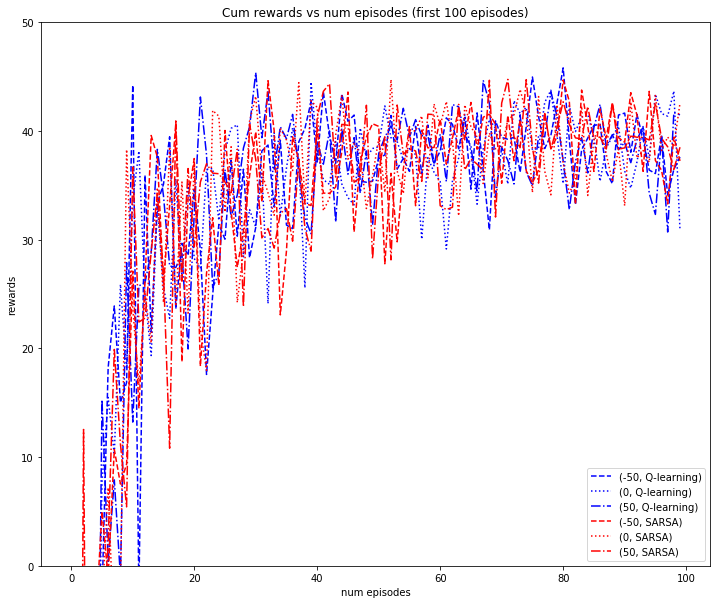

In [18]:
plt.figure(figsize=(12,10))
plt.plot(avg_100_rewards[(-50, 'Q-learning')], c='b', ls='--', label='(-50, Q-learning)')
plt.plot(avg_100_rewards[(0, 'Q-learning')], c='b', ls=':', label='(0, Q-learning)')
plt.plot(avg_100_rewards[(50, 'Q-learning')], c='b', ls='-.', label='(50, Q-learning)')
plt.plot(avg_100_rewards[(-50, 'SARSA')], c='r', ls='--',label='(-50, SARSA)')
plt.plot(avg_100_rewards[(0, 'SARSA')], c='r', ls=':',label='(0, SARSA)')
plt.plot(avg_100_rewards[(50, 'SARSA')], c='r', ls='-.',label='(50, SARSA)')
plt.legend()
plt.xlabel('num episodes')
plt.ylabel('rewards')
plt.ylim(0,50)
plt.title('Cum rewards vs num episodes (first 100 episodes)')

**Explain your results:**

*your explanation here*


**1.7** \[OPTIONAL\] Using the values of Q(s, a) you obtained for each algorithm, parameter setting, and trial, let your agent run for 5 additional episodes, but with different random action probabilities $\epsilon$ in {0, 0.01, 0.1, 0.25, 0.33, 0.5}. Store the cumulative reward obtained in each case. This metric captures how well the agent is doing once it's 'done' learning (that is, is it getting close to an optimal reward?) at different levels of action stochasticity. Then make a similar plot as in 2.6 (different color for each algorithm, different line-type for each parameter setting), but with $\epsilon$ on the x-axis and post-training, 5-episode cumulative reward (averaged over the 50 trials) on the y-axis. You may use `evaluate_static_policy` to compute the cumulative reward evaluated over 5 additional episodes.

In [ ]:
def evaluate_static_policy(env, Q, num_episodes=100, epsilon=0):
    """Returns cumulative reward following a given Q-function
    without updating Q during `num_episodes` or time steps."""
    episode_rewards = []
    while len(episode_rewards) < num_episodes:
        episode_reward = 0
        episode_iter = 0
        env.reset()
        s1 = env.observe()
        while not env.is_terminal(s1) and episode_iter < MAX_STEPS_PER_EPISODE:
            a = epsilon_greedy_action(s1, Q, epsilon)
            s1, r = env.perform_action(a)
            episode_reward += r
            episode_iter += 1
        episode_rewards.append(episode_reward)
    return np.sum(episode_rewards)

In [ ]:
# 2.7
# your code here


**Explain your results:**

*your explanation here*
